# RATINGS: scRaping and AnalyzIng biTcoIN mininG poolS
### Progetto di Fine Corso A.A. 2023/24
### Carlo Tarabbo [654342]

## Analisi Generale dei dati della Blockchain
Per prima cosa vengono fatte delle analisi sul periodo iniziale di transazioni di Bitcoin, contenute nel DataSet. 

Si studia se:
- L'andamento delle fee contenute nelle transazioni non Coinbase sono in relazione con la congestione della rete in un certo intervallo di tempo?
  
- Che tipi di script sono contenuti nel dataset e come e' cambiato il loro utilizzo nei primi 3 anni di vita di Bitcoin?

In [1]:
#per prima cosa importiamo le librerie che verranno usate per l'analisi.
import pandas as pd
import matplotlib.pyplot as plt

### Andamento delle fee rispetto alla congestione

In [4]:
# apertura e setup del dataframe delle transazioni, per ora mi interessano solo i txId che non sono coinbase e le loro fee
tdf = pd.read_csv("./datasets/transactions.csv", 
                  names=['timestamp', 'blockId', 'txId', 'isCoinbase','fee'] , 
                  dtype={'timestamp':'int32' , 'blockId':'int32', 'txId':'int32' , 'isCoinbase':'bool' , 'fee':'int64'})
tdf = tdf[tdf['isCoinbase'] == 0]
tdf.drop(['blockId', 'isCoinbase'], axis=1, inplace=True)
# print(tdf)

#creo una lista delle transazioni valide per poter filtrare gli input e output 
valid_txid = tdf['txId'].tolist()

#### Elaboro il dataset degli inputs
1. carico il dataframe degli inputs specificando il nome delle colonne il loro tipo

2. cancello dal dataframe le colonne che al momento non mi interessano

3. filtro gli inputs prendendo solamente quelli associati a transazioni non coinbase

4. creo una groupby series che mi associa ad ogni `txId` la size degli input di quella transazione

In [5]:
# apertura ed elaborazione del dataframe di inputs, filtro con i txids validi
idf =  pd.read_csv("./datasets/inputs.csv", names=['txId','prevTxId','prevTxpos'], dtype={'txId':'int32','prevTxId':'int32','prevTxpos':'int32'})
idf.drop(['prevTxpos','prevTxId'], axis=1, inplace=True)
idf = idf[idf['txId'].isin(valid_txid)]

#faccio una groupby per ottenere una series contenente quanti inputs ogni transazione ha e moltiplico per ogni txId il numero di transazioni per la loro size 
inputs_size=idf.groupby("txId").size()
inputs_size = inputs_size * 40


- elaboro il datasets con gli outputs

In [6]:
#apertura e filtro del DataSet di outputs con i txIds delle transazioni valide
odf = pd.read_csv("./datasets/outputs.csv", 
                  names=['txId', 'position', 'adressId', 'amount','scripttype'], 
                  dtype={'txId':'int32','position':'int32','adressId':'int64','amount':'int32','scripttype':'category'})
odf.drop(['position' , 'amount', 'adressId'], axis=1, inplace=True)
odf = odf[odf['txId'].isin(valid_txid)]
# print(odf)

#faccio una groupby per calcolare il peso (base) che ogni output ha
output_size = odf.groupby("txId").size()
output_size *= 9

#definisco 3 series per i vari tipi di scripttype che un output puo' avere, ignorando lo scripttype 0, assumendo una size nulla
script1_size = odf[odf['scripttype'] == '1'].groupby("txId").size()
script2_size = odf[odf['scripttype'] == '2'].groupby("txId").size()
script3_size = odf[odf['scripttype'] == '3'].groupby("txId").size()

#moltiplico ogni gruppo per la size che ha il rispettivo script
script1_size *= 153
script2_size *= 180
script3_size *= 291

#creo un dataframe unico per le output sizes usando pd.merge 
output_size = output_size.to_frame("base_size")
output_size = pd.merge(output_size , script1_size.rename("script1") , on="txId" , how="left")
output_size = pd.merge(output_size , script2_size.rename("script2") , on="txId" , how="left")
output_size = pd.merge(output_size , script3_size.rename("script3") , on="txId" , how="left")

#riempio eventuali txIds con congestione che risulta nulla
output_size["script1"] = output_size["script1"].fillna(0)
output_size["script2"] = output_size["script2"].fillna(0)
output_size["script3"] = output_size["script3"].fillna(0)

#calcolo la colonna del contributo alla congestione generata dagli outputs di una determinata transazione sommando le size delle sue componenti
output_size['tx_output_size'] = output_size['base_size'] + output_size['script1'] + output_size['script2'] + output_size['script3']

print(output_size)

          base_size  script1  script2  script3  tx_output_size
txId                                                          
171              18    306.0      0.0      0.0           324.0
183              18    306.0      0.0      0.0           324.0
185              18    306.0      0.0      0.0           324.0
187              18    306.0      0.0      0.0           324.0
192               9    153.0      0.0      0.0           162.0
...             ...      ...      ...      ...             ...
10572822         18      0.0    360.0      0.0           378.0
10572823         18      0.0    360.0      0.0           378.0
10572824         18      0.0    360.0      0.0           378.0
10572825         18      0.0    360.0      0.0           378.0
10572826         27      0.0    540.0      0.0           567.0

[10358266 rows x 5 columns]


### Creazione della colonna congestione (per transazione)
La formula della congestione dell'impatto di una transazione e' la seguente: 

- `size(transaction)= size(input)* n_inputs+ size (output)* n_outputs + sizes (script)`

Definisco un dataframe `data` dove calcolo la congestione e la metto, per ogni txId, assieme alle fee guadagnate e allo *unix timestamp* della transazione, che verra' utilizzato per creare delle time series e visualizzare temporalmente i dati.

In [7]:
data = output_size['tx_output_size'] + inputs_size
data=data.to_frame('congestione')
# tramite una merge associo alle transazioni fees e timestamp dal dataframe con i dati delle transazioni
data = pd.merge(data , tdf[["txId", "fee","timestamp"]] , on="txId" , how="left")
data

,txId,congestione,fee,timestamp
0,171,364.0,0,1231731025
1,183,364.0,0,1231740133
2,185,364.0,0,1231740736
3,187,364.0,0,1231742062
4,192,202.0,0,1231744600
...,...,...,...,...
10358261,10572822,418.0,100000,1356997957
10358262,10572823,418.0,100000,1356997957
10358263,10572824,418.0,100000,1356997957
10358264,10572825,418.0,100000,1356997957


In [6]:
# Opzionale: Salvo la tabella dei dati
data.to_csv('./datasets/analisi_congestione.csv' , index=False)

### Dalla congestione delle singole transazioni all'analisi temporale del rapporto tra congestione e fees

Ora che abbiamo un DataSet che contiene tutti i dati di interesse per le diverse transazioni nei primi anni della Blockchain di Bitcoin, possiamo continuare con l'analisi temporale del rapporto tra Fees e Congestione.

Per l'analisi verra' scelto un quanto di tempo (`qdt`) di una settimana per confrontare le fees rilasciate rispetto alla congestione.

La congestione verra' espressa in `B`, le fees invece verranno lasciate nell'unita' di misura originale (`satoshi`).

L'approccio che verra' preso consiste in un resample settimanale del DataSet contenete i dati di interesse.

In [8]:
#apro sulla variabile tdf il dataset calcolato prima
data = pd.read_csv('./datasets/analisi_congestione.csv' , dtype={'timestamp':'int64' , 'txId':'int32' , 'fee':'int64' , 'congestione':'int64'})

In [8]:
# conversione del tempo da UNIX timestamp a data
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

#resample del dataset, settimanalmente prendo la somma delle congestioni delle transazioni e la media delle fee rilasciate
#ottengo cosi' il timestamp come index e 'fee' e 'congestione' come colonne
mean_tdf = pd.DataFrame()
mean_tdf['fee'] = data.resample('ME', on='timestamp')[['fee']].sum()
mean_tdf['congestione'] = data.resample('ME' , on='timestamp')['congestione'].sum()

mean_tdf


,fee,congestione
timestamp,,
2009-01-31,0,12875.0
2009-02-28,201000000,17536.0
2009-03-31,0,13970.0
2009-04-30,0,11458.0
2009-05-31,13000000,10163.0
2009-06-30,0,5666.0
2009-07-31,14000000,6511.0
2009-08-31,13000000,8260.0
2009-09-30,12000000,12721.0


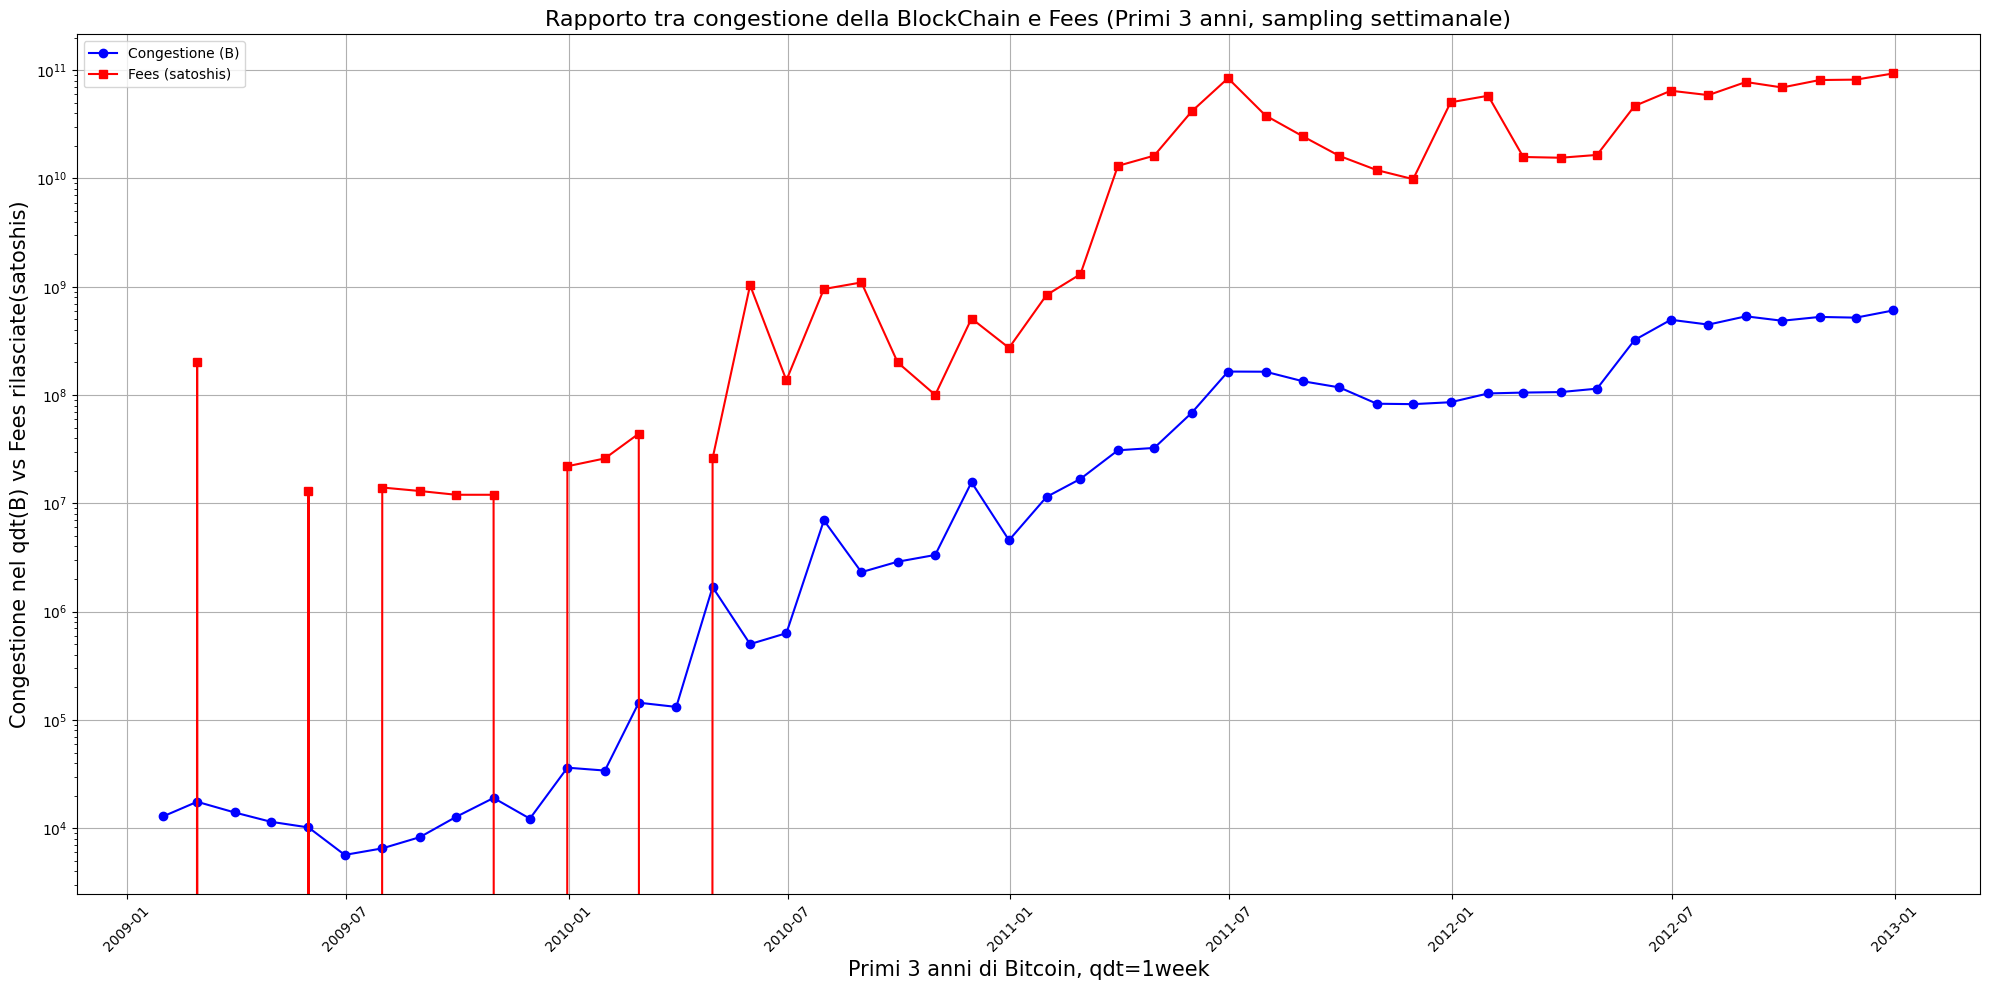

In [9]:
#creazione del grafico di comparazione con pyplot
plt.rcParams['agg.path.chunksize'] = 1000  # Aumento la chunksize per evitare problemi con plot con molti dati

plt.figure(figsize=(20, 10))  # Dimensione della figura

# Plot congestione 
plt.plot(mean_tdf.index, mean_tdf['congestione'], label='Congestione (B)', marker='o', color='b')

# Plot fee
plt.plot(mean_tdf.index, mean_tdf['fee'], label='Fees (satoshis)', marker='s', color='r')

# Imposto la scala logaritmica per l'asse delle y per rendere le differenze piu' evidenti e comprensibili
plt.yscale('log')  # Set y-axis to logarithmic scale for fee

# Imposto le label varie
plt.xlabel("Primi 3 anni di Bitcoin, qdt=1week", fontsize=15)
plt.ylabel("Congestione nel qdt(B) vs Fees rilasciate(satoshis)", fontsize=15)
plt.title("Rapporto tra congestione della BlockChain e Fees (Primi 3 anni, sampling settimanale)", fontsize=16) #Titolo
plt.xticks(rotation=45)  # Ruoto le label dell'asse delle x per renderlo piu' semplice da leggere
plt.grid(True)  
plt.legend()  

plt.tight_layout()  # Aggiusto lo spacing tra gli elementi
plt.show()

Dal grafico si puo' vedere che sembra esserci una correlazione tra la congestione della blockchain e la quantita' di fees rilasciate ai miner. Si nota bene soprattutto a partire dall'ottobre 2010, dove la blockchain inizia ad essere piu' utilizzata. Questo porta a non presentare piu' periodi di "silenzio" dove il numero di transazioni, e di conseguenza fees e congestione, e' molto basso o minimo.

Questa relazione pero' non e' l'unica che va a influire sul valore delle fees rilasciate durante il mining: altre variabili che, per esempio, possono influire sono il prezzo della moneta, le ricompense offerte ai miner e la disponibilita' e potenza dell'hardware per minare disponibile al tempo.

### Analisi del tipo di script utilizzati dalle transazioni

In [10]:
#riapro il dataset delle transazioni non filtrato
tdf = pd.read_csv("./datasets/transactions.csv", 
                  names=['timestamp', 'blockId', 'txId', 'isCoinbase','fee'] , 
                  dtype={'timestamp':'int32' , 'blockId':'int32', 'txId':'int32' , 'isCoinbase':'bool' , 'fee':'int64'})

#riapro il DataSet di outputs con i txIds, questa volta senza filtrare quelli "validi"
odf = pd.read_csv("./datasets/outputs.csv", names=['txId', 'position', 'adressId', 'amount','scripttype'], dtype={'txId':'int32','position':'int32','adressId':'int64','amount':'int32','scripttype':'category'})
odf.drop(['position' , 'amount', 'adressId'], axis=1, inplace=True)
# print(odf)

#creo una counts series e la coverto a dataframe 
counts = pd.DataFrame(odf.value_counts())

In [ ]:
#creo un dataframe typedf che contiene i timestamps e i txIds del dataframe delle transazioni
typedf = pd.DataFrame()
typedf[['timestamp','txId']] = tdf[['timestamp','txId']]


#aggiungo al dataframe typedf le volte che ogni tipo di script e' stato utilizzato da una transazione

for script_type , new_df in counts.groupby(level=1):
    # output_df.append(new_df['count'])
    new_df.set_index(new_df.index.get_level_values(0), inplace=True)
    new_df.rename(columns={'count' : script_type}, inplace=True)
    typedf = pd.merge(
        typedf,
        new_df[script_type],
        on='txId',
        how='left',
    )

#riempio i NaN creati dalla merge con 0 per poterci creare il grafico 
typedf.fillna(0, inplace=True)
# print(typedf)

#### creazione dei diversi dataframes per i tipi di script

Creo un dataframe differente per ogni tipo di script, fancendo un resample per ottenere il numero di volte che ogni script e' stato utilizzato.

Utilizzo dataframe diversi perche' i diversi tipi di script sono stati introdotti in periodi di tempo differenti e un resample generale potrebbe portare a una perdita di dati.

In [12]:
#formatto i timestamp come data
typedf['timestamp'] = pd.to_datetime(typedf['timestamp'], unit='s')

#creo il dataframe con i dati settimanali
weekly_typedf = pd.DataFrame()

#definisco i valori degli utilizzi settimanali dei diversi tipi di script 
weekly_typedf['0'] = typedf.resample('2W-MON' , on='timestamp')['0'].sum()
weekly_typedf['1'] = typedf.resample('2W-MON' , on='timestamp')['1'].sum()
weekly_typedf['2'] = typedf.resample('2W-MON' , on='timestamp')['2'].sum()
weekly_typedf['3'] = typedf.resample('2W-MON' , on='timestamp')['3'].sum()

weekly_typedf

,0,1,2,3
timestamp,,,,
2009-01-05,0.0,1.0,0.0,0.0
2009-01-19,0.0,1109.0,2.0,0.0
2009-02-02,0.0,1711.0,7.0,0.0
2009-02-16,0.0,1816.0,10.0,0.0
2009-03-02,0.0,1572.0,4.0,0.0
...,...,...,...,...
2012-11-05,241.0,23592.0,893702.0,10.0
2012-11-19,213.0,20614.0,1078752.0,5.0
2012-12-03,242.0,18176.0,1074131.0,3.0


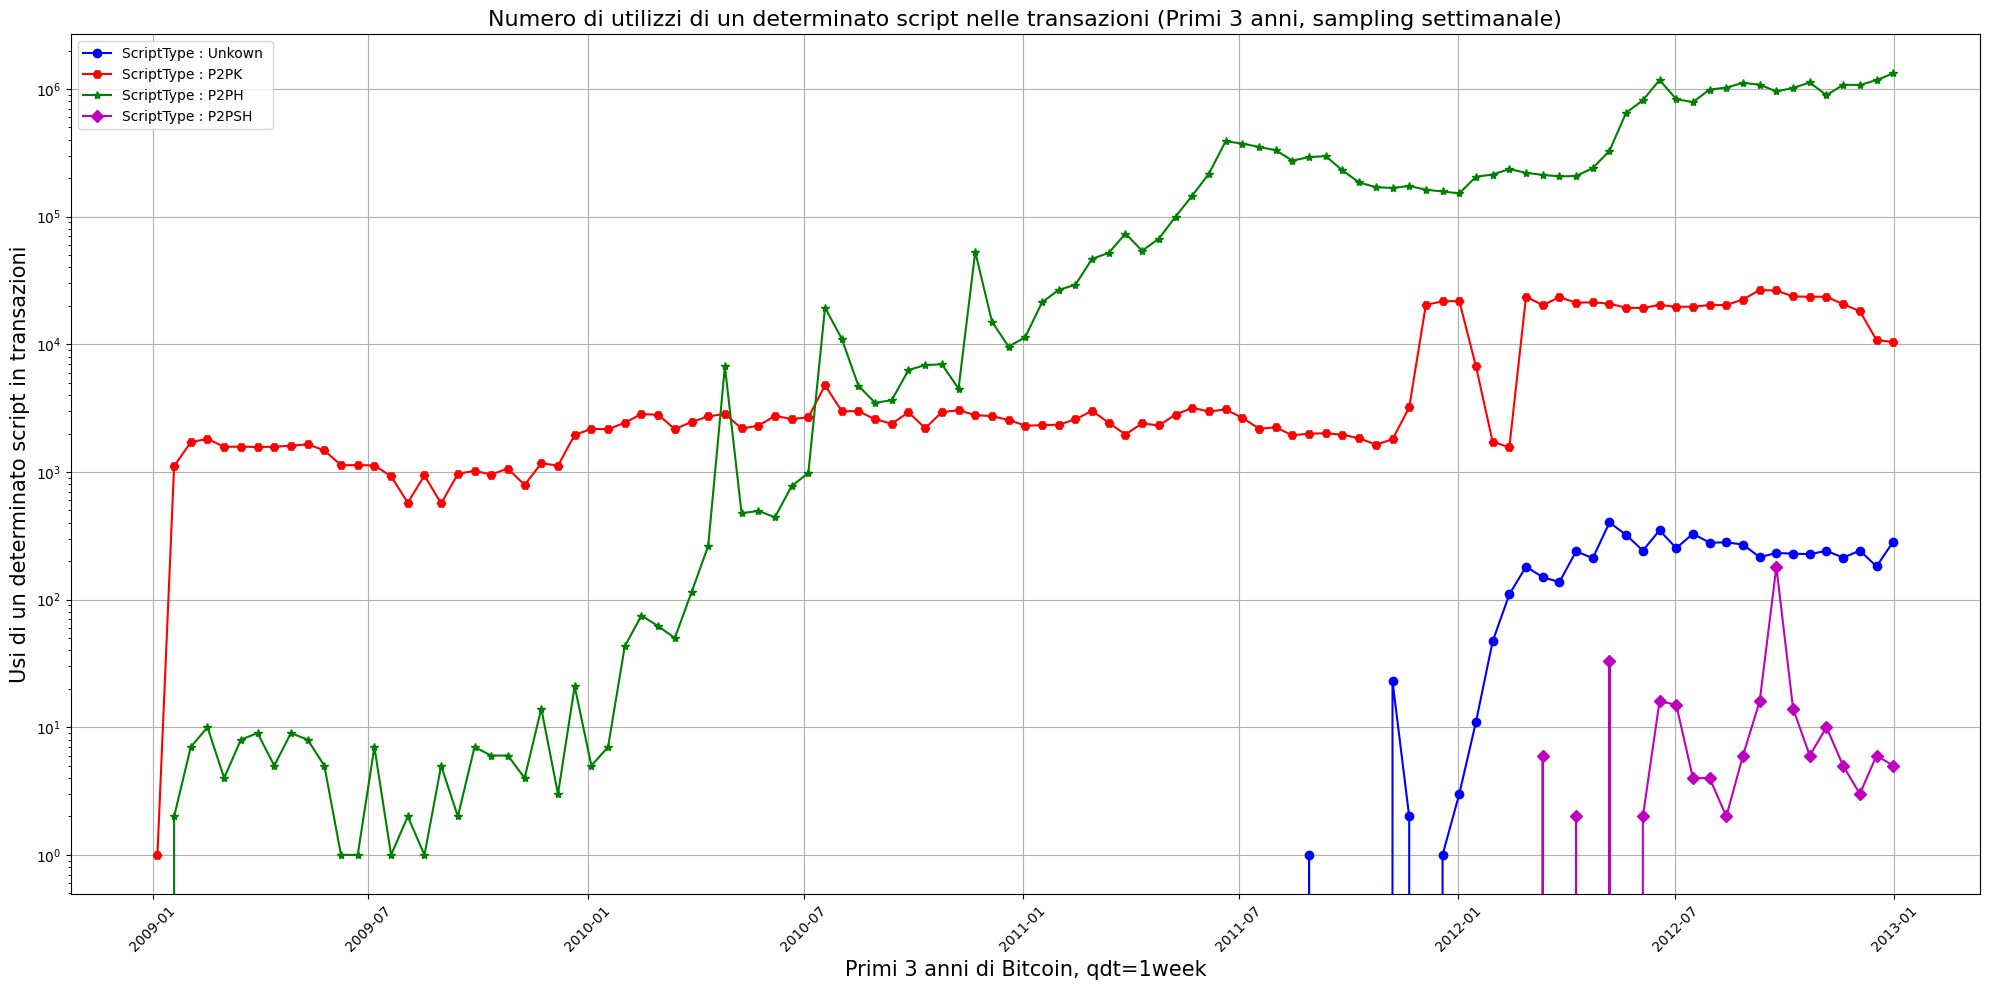

In [13]:
#creazione del grafico di comparazione con pyplot
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 1000  # Aumento la chunksize per evitare problemi con plot con molti dati

plt.figure(figsize=(20, 10))  # Dimensione della figura

# Plot 0 
plt.plot(weekly_typedf.index, weekly_typedf['0'], label='ScriptType : Unkown ', marker='o', color='b')
# Plot 1 
plt.plot(weekly_typedf.index, weekly_typedf['1'], label='ScriptType : P2PK ', marker='H', color='r')
# Plot 2
plt.plot(weekly_typedf.index, weekly_typedf['2'], label='ScriptType : P2PH ', marker='*', color='g')
# Plot 3
plt.plot(weekly_typedf.index, weekly_typedf['3'], label='ScriptType : P2PSH ', marker='D', color='m')



# Imposto la scala logaritmica per l'asse delle y per rendere le differenze piu' evidenti e comprensibili
plt.yscale('log')

# Imposto le label varie
plt.xlabel("Primi 3 anni di Bitcoin, qdt=1week", fontsize=15)
plt.ylabel("Usi di un determinato script in transazioni", fontsize=15)
plt.title("Numero di utilizzi di un determinato script nelle transazioni (Primi 3 anni, sampling settimanale)", fontsize=16) #Titolo
plt.xticks(rotation=45)  # Ruoto le label dell'asse delle x per renderlo piu' semplice da leggere
plt.grid(True)  
plt.legend()  

plt.tight_layout()  # Aggiusto lo spacing tra gli elementi
plt.show()

# Analisi delle Mining Pools

In questa parte di RATINGS viene implementato un web scraper con lo scopo di deanonimizzare gli indirizzi contenuti nelle Coinbase del dataset fornito, per poter analizzare il comportamento delle mining pool attive in un dato periodo.

Il periodo considerato e' dalla creazione del primo blocco Genesis fino alla fine del 2012. In questo periodo alcune delle mining pool piu' attive sono state DeepBit(la piu' importante), Eligius, BTC Guild e BitMinter, come evidenziato nella paper "The Evolution of Mining Pools and Miners’ , Behaviors in the Bitcoin Blockchain, Fig.2"

Lo scraper utilizza la libreria BeautifulSoup, sufficiente dato che [WalletExplorer](https://www.walletexplorer.com/) non carica le pagine dinamicamente attraverso script in javascript.

Per ogni Mining Pool verra' scrapeata la intera tabella dei dati per poi essere salvata come `.csv` per la successiva analisi.

Utilizzo la libreria `fake_useragent` e il sito [sslproxies](https://www.sslproxies.org/') per utilizzare proxies per mascherare l'indirizzo ip delle richieste e ciclarle su ip differenti per velocizzare il processo di scraping.

### Librerie utilizzate per il processo di scraping

In [18]:
# per lo scraping 
from bs4 import BeautifulSoup as bs 
import requests

#per proxies
from fake_useragent import UserAgent
from urllib.request import Request, urlopen

# per filtrare la tabella e esportarla in file csv
import pandas as pd 
# come librerie di utilities
import re
import time
import random

### Funzioni di supporto per Proxy e chiamate con requests

#### `generate_proxies()`
Utilizzo il sito [sslproxies](https://www.sslproxies.org/) per ottenere una lista di proxies da utilizzare per le chiamate requests

In [19]:
ua = UserAgent() 

# Lista che conterrà i proxy come dizionari con chiavi ip e porta
proxies = [] 
# Funzione per la estrazione dei proxy da sslproxies.org
def generate_proxies():
    proxies.clear() # Svuoto la lista dei proxy (nel caso la funzione venga chiamata più volte non si vogliono avere duplicati)
    proxies_req = Request('https://www.sslproxies.org/')
    proxies_req.add_header('User-Agent', ua.random)
    proxies_doc = urlopen(proxies_req).read().decode('utf8')
    soup = bs(proxies_doc, 'html.parser')
    proxies_table = soup.find('table', class_='table table-striped table-bordered')
    # Salvo i proxy nella lista proxies
    for row in proxies_table.tbody.find_all('tr'):
        td = row.find_all('td')
        proxies.append({
        'ip':   td[0].string,
        'port': td[1].string})
 
# Proxy ottenuti da sslproxies.org
generate_proxies()
print(f"Numero di proxy ottenuti da sslproxies.org: {len(proxies)}")
# print(proxies)

Numero di proxy ottenuti da sslproxies.org: 100


#### `get_request_page()`
args:
- url del sito a cui fare la richiesta
- lista dei proxies ottenuta da `generate_proxies()`

In [20]:
def get_request_page(url, proxies):
    original_proxy_count = len(proxies)
    while True:
        if len(proxies) == 0:
            print(f"Numero massimo di proxy bloccati raggiunto. Ne prendo di nuovi. ({original_proxy_count})")
            raise StopIteration
        proxy = random.choice(proxies)
        # print("uso il proxy : ",proxy)
        user_agent = ua.random
        try:
            headers = {'User-Agent': user_agent}
            response = requests.get(url, headers=headers, proxies=proxy)
            # print(response)
            soup = bs(response.text, 'html.parser')
            if response.text.startswith("Too"):
                 proxies.remove(proxy)
                 print(f"WalletExplorer ha bloccato l'IP del proxy. Cambio proxy... (numero di proxy rimanenti: {len(proxies)})")
                 time.sleep(5)  # Attendi 5 secondi prima di provare un nuovo proxy
                 continue
            
            #se ho una risposta OK, restituisco la risposta e l'oggetto response
            return response        
        except:
            proxies.remove(proxy)
            print(f"Errore durante la richiesta. Cambio proxy... (numero di proxy rimanenti alla sospensione dell'esecuzione: {len(proxies)})")
            time.sleep(5)  # Attendi 5 secondi prima di provare un nuovo proxy
            continue

#### Struttura dei dati che vengono salvati e gestiti
Il sito presenta una tabella contenente varie tipologie di date, da cui verranno estratte:
- l' `hash` del wallet della mining pool
- il numero di transazioni in arrivo `incoming_tsx`
- il numero dell'ultimo blocco in cui e' stato utilizzato , `last_usedin_block`

Lo scraper lavora su 3 livelli :
1. i dati dell'intera mining pool
2. i dati della singola pagina della tabella
3. i dati della singola riga

Finite le pagine converte la lista di dizionari python in un dataframe `pandas`, per poi salvarlo.



In [ ]:
# definisco la lista delle coinbase che devono essere scrapeate e l'indirizzo base del sito
coinbase_links = [ 'Eligius.st' , 'BTCGuild.com' , 'BitMinter.com', 'DeepBit.net']
base_url="https://www.walletexplorer.com/wallet/" 

# main for loop 
for coinbase_link in coinbase_links : 
  #faccio una prima richiesta della prima pagine fornita alla ricerca di un Wallet ed estraggo il numero di pagine della tabella 
  url = base_url +  coinbase_link + '/addresses'
  r = requests.get(url)
  html_text = r.text
  soup = bs(html_text , 'html.parser')

  # definisco una lista dove verranno salvati, come oggetti, tutte le diverse righe della tabella
  coinbase_data = []

  #estraggo usando una regex il numero di pagine
  paging = soup.find('div' , attrs={'class' : 'paging'}).text
  numbers = re.findall(r'\d+' , paging)
  coinbase_pages = int(numbers[1])
  #parto dalla pagina 1 
  page = 1

  #main scaper loop, divido il lavoro per pagine
  while page <= coinbase_pages:
    #dati della pagina
    page_data = []

    #definisco il link per la richiesta
    if page == 1 :
      url = base_url + coinbase_link + '/addresses'
    else :
      url = base_url + coinbase_link + '/addresses?page=' + str(page)
    
    #provo a fare la richiesta con la lista proxies che ho, nel caso in cui fallisca ne genero di nuovi e ripeto la chiamata
    try :
      r = get_request_page(url, proxies)
    except:
        proxies = generate_proxies()
        r = get_request_page(url, proxies)
        
    html_text = r.text
    soup = bs(html_text , 'html.parser')

    print(f"scraping page n : {page} at {url}")

    page = page + 1

    #seleziono la tabella
    tsx_table = soup.find("table")

    #prendo tutte le rows dalla seconda in poi per evitare la table header
    for row in tsx_table.find_all("tr")[1::]:

      row_data = row.find_all('td')

      #definisco l'oggetto entry da aggiungere alla lista
      entry = {}
      #data della transazione
      entry['hash'] = row_data[0].text
      entry['incoming_txs'] = row_data[2].text.replace("&nbsp;" , "")
      entry['last_usedin_block'] = row_data[3].text
      
      page_data.append(entry)

    #se tutta la pagina e' stata scrapeata correttamente viene aggiunta alla lista di dati della mining Pool
    for entry in page_data : coinbase_data.append(entry)



  df = pd.DataFrame(coinbase_data)
  # print(df)
  df.to_csv('./datasets/' + coinbase_link.replace(".", "_")+'.csv', index=True)

Ora ho un serie di file `csv` che contengono tutti gli indirizzi che sono contenuti nei wallet delle diverser Mining Pool. 

Devo collegare gli hash del sottoinsieme di transazioni coinbase del dataframe `output` con gli hash dei diversi indirizzi nei wallet delle Mining Pool. 

Per fare questo devo prima passare attraverso il DataFrame `mapping` per convertire gli identificatori `adressId` con gli `hash` corrispondenti, per deanonimizzarlo

In [17]:
import pandas as pd
#apro il dataframe degli outputs
odf = pd.read_csv("./datasets/outputs.csv", 
                  names=['txId', 'position', 'adressId', 'amount','scripttype'], 
                  dtype={'txId':'int32','position':'int32','adressId':'int64','amount':'int64','scripttype':'category'})
odf.drop(['position' , 'amount', 'scripttype'], axis=1, inplace=True)

#apro il dataframe del mappings per linkare gli adressId con gli hash
mapping = pd.read_csv("./datasets/mapping.csv" , names=['hash' , 'adressId'])

odf = pd.merge(odf,
                 mapping,
                 on='adressId',
                 how="left"
)

Ora utilizzo i dataframe ottenuti da `WalletExplorer` per deanonimizzare gli indirizzi e associare, quando possibile, ogni hash ad uno delle Mining Pools

In [ ]:
coinbases = [ 'Eligius_st' , 'BitMinter_com', 'DeepBit_net', 'BTCGuild_com']

#aggiungo una colonna al dataframe degli outputs con valore standard Other
odf['mining_pool'] = "Other"

#per ogni coinbase
for coinbase in coinbases : 
  #leggo il file degli indirizzi di quella coinbase e prendo la lista degli hash
  coinbase_df = pd.read_csv(f'./datasets/{coinbase}.csv')
  adress_list = coinbase_df['hash'].to_list()

  #per tutti gli hash in quella lista vado a modificare il valore di mining_pool a quello della mining_pool a cui appartengono
  temp = odf[odf['hash'].isin(adress_list)]
  temp['mining_pool'] = coinbase
  odf[odf['hash'].isin(adress_list)] = temp

In [31]:
#salvo il df
odf.to_csv('./datasets/wallets_deanonimizzati.cvs', index=False)

### Deanonimizzazione dei top 4 miners ancora anonimi

Ora invece vado a controllare e flaggare quali sono le 4 top mining pools non ancora deanonimizzate.

Per farlo uso una combinazione di `Selenium` e `Beautifulsoup` per lo scraping delle pagine. Selenium viene usato per interagire con la barra di ricerca di walletexplorer, beautifulsoup per lo scraping delle tabelle con i wallet.

Verranno utilizzate le funzioni per aiutare lo scraper con proxies definite sopra.

#### Come provo a deanonimizzare
Il Procedimento che ho deciso di utilizzare per la deanonimizzazione degli hash con mining pool _"Other"_ consiste nel selezionare, per 4 volte, l'hash nel dataframe degli outputs che viene utilizzato piu' volte.

Da questo hash, tramite _walletexplorer_, scarico e deanonimizzo nel dataframe degli outputs tutti gli wallet associati a quel determinato hash.

A questo punto ho deanonimizzato un insieme di indirizzi e ripeto il procedimento, riottenendo l'hash piu' utilizzato.

Questo procedimento non _garantisce_ di ottenere i miners che hanno prodotto piu' transazioni, dato che potrebbe esserci un miner con un numero estremamente elevato di wallet, ma con poche transazioni per wallet.

Si incontra pero' un problema utilizzando un approccio "brute-force" e provando a deanonimizzare tutti gli indirizzi tra gli outputs. Il numero di richieste da fare al sito porterebbe a un tempo per lo scraping estremamente elevato. Questo non tenendo conto che, per esempio, all'interno delle transazioni si trovano wallet associati alla mining pool [CoinJoinMess](https://www.walletexplorer.com/wallet/CoinJoinMess/addresses), che presenta 52843 pagine della tabella di wallet associati.

In [19]:
#riapro il dataset delle transazioni non filtrato
tdf = pd.read_csv("./datasets/transactions.csv", 
                  names=['timestamp', 'blockId', 'txId', 'isCoinbase','fee'] , 
                  dtype={'timestamp':'int32' , 'blockId':'int32', 'txId':'int32' , 'isCoinbase':'bool' , 'fee':'int64'})

valid_txid = tdf[tdf['isCoinbase']==1]['txId'].tolist()

#prendo le transazioni coinbase

coinbases_df = odf[odf['txId'].isin(valid_txid)] 

#valid_txid e' la lista degli txid Coinbase definita all'inizio del progetto, all'apertura del transactions dataframe

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import requests
import re


# definisco il chromedriver per selenium
chrome_options = webdriver.ChromeOptions() 
chrome_options.add_argument('--headless')  # Headless mode per non aprire la finestra
chrome_options.add_argument('--disable-gpu')  
chrome_options.add_argument('--no-sandbox')
driver = webdriver.Chrome(options=chrome_options) # Creo il diver usando le specifiche definite
driver.minimize_window()

#Ripeto per 4 volte per ottenere i top 4 mining pools non ancora deanonimizzate
for i in range(4):
  #definisco un df con le transazioni che non hanno ancora una mining pool definita 
  # others = odf[odf['mining_pool']=='Other'].groupby(['hash']).size()
  others = coinbases_df[coinbases_df['mining_pool']=='Other'].groupby(['hash']).size()
  #prendo la transazione con piu' outputs e la setto come wallet_hash da investigare
  # print(others.sort_values(ascending=False).head(1))
  wallet_hash = others.sort_values(ascending=False).index[0]

  #usando il driver di selenium faccio una ricerca del wallet_hash che sto controllando
  driver.get("https://www.walletexplorer.com/")
  input_field = driver.find_element(By.XPATH,'//*[@id="main"]/form/p/label/input')
  input_field.send_keys(wallet_hash)
  input_field.send_keys(Keys.ENTER)

  #prendo il nome del wallet da [https: , , www... , wallet , miner , ...] , da cui prendo il nome prima del ?from_adress... nell'indirizzo
  # miner = driver.find_element(By.TAG_NAME, 'h2').text.split(" ")[1]
  miner = driver.current_url.split("/")[4].split("?")[0]
  print(f"miner : {miner}")

  
  #definisco la lista degli wallet_adresses associati a quella mining pool
  wallet_adresses_list = []
  
  #ripeto un processo di scraping simile a quello fatto per le 4 mining pool date
  r = requests.get(f"https://www.walletexplorer.com/wallet/{miner}/addresses")
  soup = bs(r.text , "html.parser")

  paging = soup.find('div' , attrs={'class' : 'paging'}).text
  numbers = re.findall(r'\d+' , paging)
  coinbase_pages = int(numbers[1])
  #parto dalla pagina 1 
  page = 1

  #main scaper loop, divido il lavoro per pagine
  while page <= coinbase_pages:
    #dati della pagina
    page_data = []

    #definisco il link per la richiesta
    if page == 1 :
      url = f"https://www.walletexplorer.com/wallet/{miner}/addresses"
    else :
      url = f"https://www.walletexplorer.com/wallet/{miner}/addresses?page={str(page)}"
    
    #provo a fare la richiesta con la lista proxies che ho, nel caso in cui fallisca ne genero di nuovi e ripeto la chiamata
    try :
      r = get_request_page(url, proxies)
    except:
        proxies = generate_proxies()
        r = get_request_page(url, proxies)
        
    html_text = r.text
    soup = bs(html_text , 'html.parser')

    # print(f"scraping page n : {page} at {url}")

    page = page + 1

    #seleziono la tabella
    tsx_table = soup.find("table")

    #prendo tutte le rows dalla seconda in poi per evitare la table header
    for row in tsx_table.find_all("tr")[1::]:

      row_data = row.find_all('td')
      wallet_adresses_list.append(row_data[0].text)

  #definisco un dataframe temporaneo dove cambio la "mining_pool" da unkown alla mining_pool appena deanonimizzata, per tutti i suoi indirizzi
  temp = coinbases_df[coinbases_df['hash'].isin(wallet_adresses_list)]
  temp['mining_pool'] = miner
  #vado a modificare i valori di quella mining pool da other al nome
  odf[odf['hash'].isin(wallet_adresses_list)] = temp
  coinbases_df[coinbases_df['hash'].isin(wallet_adresses_list)] = temp
  # print(odf[odf['mining_pool'] == miner])

In [21]:
odf.to_csv('./datasets/wallets_deanonimizzati.cvs')

# Analisi delle coinbase deanonimizzate

## Calcolo del numero di blocchi minati dalle differenti mining pools analizzate

In [1]:
import pandas as pd
odf = pd.read_csv('./datasets/wallets_deanonimizzati.cvs')
# print(odf)

Facendo una merge tra il dataframe di hash deanonimizzati e quello delle transazioni si puo' andare a datare ogni transazione, che ci permette di fare una analisi temporali dei diversi blocchi minati dalle 4 mining pools

In [2]:
#riapro il dataframe delle transazioni
tdf = pd.read_csv("./datasets/transactions.csv", 
                  names=['timestamp', 'blockId', 'txId', 'isCoinbase','fee'] , 
                  dtype={'timestamp':'int32' , 'blockId':'int32', 'txId':'int32' , 'isCoinbase':'bool' , 'fee':'int64'},
                  )
valid_txid = tdf[tdf['isCoinbase']==1]['txId'].to_list()

- Faccio una merge tra outputs e transazioni per associare ad ogni transazione una `fee` e un `timestamp`

In [3]:
odf = pd.merge(
  odf , 
  tdf[["timestamp" , "txId" , "fee", "blockId"]],
  on="txId",
  how="left"
)

- converto i timestamp da UNIX timestamp a date

In [4]:
odf['timestamp'] = pd.to_datetime(odf['timestamp'], unit='s')

odf.head()

,Unnamed: 0,txId,adressId,hash,mining_pool,timestamp,fee,blockId
0,0,0.0,0.0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,Other,2009-01-03 18:15:05,0.0,0.0
1,1,1.0,1.0,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,Other,2009-01-09 02:54:25,0.0,1.0
2,2,2.0,2.0,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,Other,2009-01-09 02:55:44,0.0,2.0
3,3,3.0,3.0,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,Other,2009-01-09 03:02:53,0.0,3.0
4,4,4.0,4.0,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,Other,2009-01-09 03:16:28,0.0,4.0


- Definisco i dataframe con un resample + count per il numero di blocchi di ciascuna Mining Pool

#### 0.1 Dataframe con resample del numero di blocchi unici minati dalle 4 minin pools date

In [5]:

# Dataframe per Eligius
Eligius_df = pd.DataFrame()
Eligius_df = odf[odf['mining_pool'] == "Eligius_st"].resample('2ME' , on='timestamp')[['blockId']].count().rename(columns={"blockId":"blocks"})


# Dataframe per BitMinter
BitMinter_df = pd.DataFrame()
BitMinter_df = odf[odf['mining_pool'] == "BitMinter_com"].resample('2ME' , on='timestamp')[['blockId']].count().rename(columns={"blockId":"blocks"})

# Dataframe per DeepBit
DeepBit_df = pd.DataFrame()
DeepBit_df = odf[odf['mining_pool'] == "DeepBit_net"].resample('2ME' , on='timestamp')[['blockId']].count().rename(columns={"blockId":"blocks"})


# Dataframe per BTCGuild
BTCGuild_df = pd.DataFrame()
BTCGuild_df = odf[odf['mining_pool'] == "BTCGuild_com"].resample('2ME' , on='timestamp')[['blockId']].count().rename(columns={"blockId":"blocks"})



- definisco ora i dataframe per i 4 miner/mining pool che si e' cercato di deanonimizzare.

Per l'unica a cui e' stato associato un nome vero e proprio per la pool si usera' il suo nome, per le altre 3 rimaste anonime verra' associato il nome miner(i)_df

- miner1 : `019a46b8d84bf5b5`

- miner2 : `3e486bf1d3615fb8`

- miner3 : `01a990df756979ef`

Dato che le mining pool deanonimizzate hanno transazioni che, a parte `019a` che inizia da fine 2011, iniziano verso la fine del 2012, per rendere i grafici piu' interessanti di due valori, diminiusco il rate di resampling da 2 mesi a 2 settimane

#### Dataframe con un resample bisettimanale del numero di blocchi minati dai 4 miner deanonimizzati

In [6]:

miner1_df = pd.DataFrame()
miner1_df = odf[odf['mining_pool'] == "019a46b8d84bf5b5"].resample('2W' , on='timestamp')[['blockId']].count().rename(columns={"blockId":"blocks"})


miner2_df = pd.DataFrame()
miner2_df = odf[odf['mining_pool'] == "3e486bf1d3615fb8"].resample('2W' , on='timestamp')[['blockId']].count().rename(columns={"blockId":"blocks"})


EclipseMC_df = pd.DataFrame()
EclipseMC_df = odf[odf['mining_pool'] == "EclipseMC.com-old"].resample('2W' , on='timestamp')[['blockId']].count().rename(columns={"blockId":"blocks"})


miner3_df = pd.DataFrame()
miner3_df = odf[odf['mining_pool'] == "01a990df756979ef"].resample('2W' , on='timestamp')[['blockId']].count().rename(columns={"blockId":"blocks"})



## Analisi sui blocchi minati

#### Numero di blocchi minati in totale

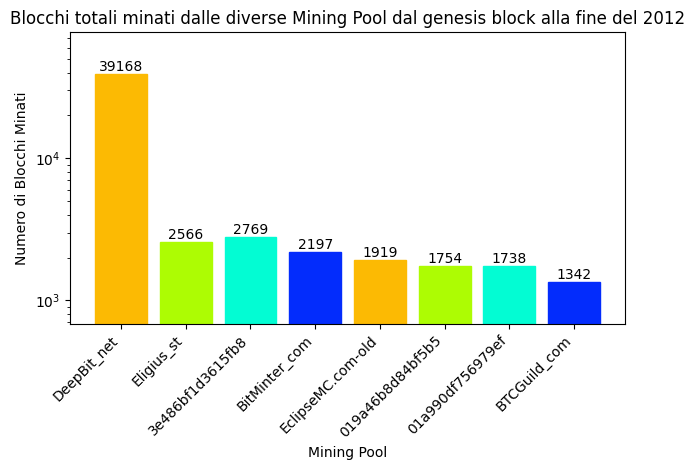

In [7]:
import matplotlib.pyplot as plt
blocks_mined = odf[odf["mining_pool"] != "Other"]
blocks_mined = blocks_mined["mining_pool"].value_counts()
blocks_mined = pd.DataFrame(blocks_mined)

mining_pools_list =['DeepBit_net','Eligius_st','3e486bf1d3615fb8','BitMinter_com', 'EclipseMC.com-old', '019a46b8d84bf5b5', '01a990df756979ef','BTCGuild_com']
pools = []

#per ogni mining pool prendo il numero di blocchi unici che appartengono alle diverse mining pools
for mining_pool in mining_pools_list:
  pools.append( len(odf[odf['mining_pool'] == mining_pool]['blockId'].unique()))

fig, ax = plt.subplots()
bars = ax.bar(mining_pools_list , pools)
ax.bar_label(bars)

bars[0].set_color("#fcba03")
bars[1].set_color("#adfc03")
bars[2].set_color("#03fcd3")
bars[3].set_color("#032cfc")
bars[4].set_color("#fcba03")
bars[5].set_color("#adfc03")
bars[6].set_color("#03fcd3")
bars[7].set_color("#032cfc")

# Customize the plot further (title, labels, etc.)
plt.yscale('log')
plt.title("Blocchi totali minati dalle diverse Mining Pool dal genesis block alla fine del 2012")
plt.xlabel("Mining Pool")
plt.ylabel("Numero di Blocchi Minati")

#aggingo un po' di margine
ax.margins(y=0.2)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align right
plt.tight_layout()
plt.show()

#### 1.2 Numero di blocchi minati con sampling bimensile

Per questo grafico uso i resample fatti nel punto 0.1 per il numero di blocchi minati

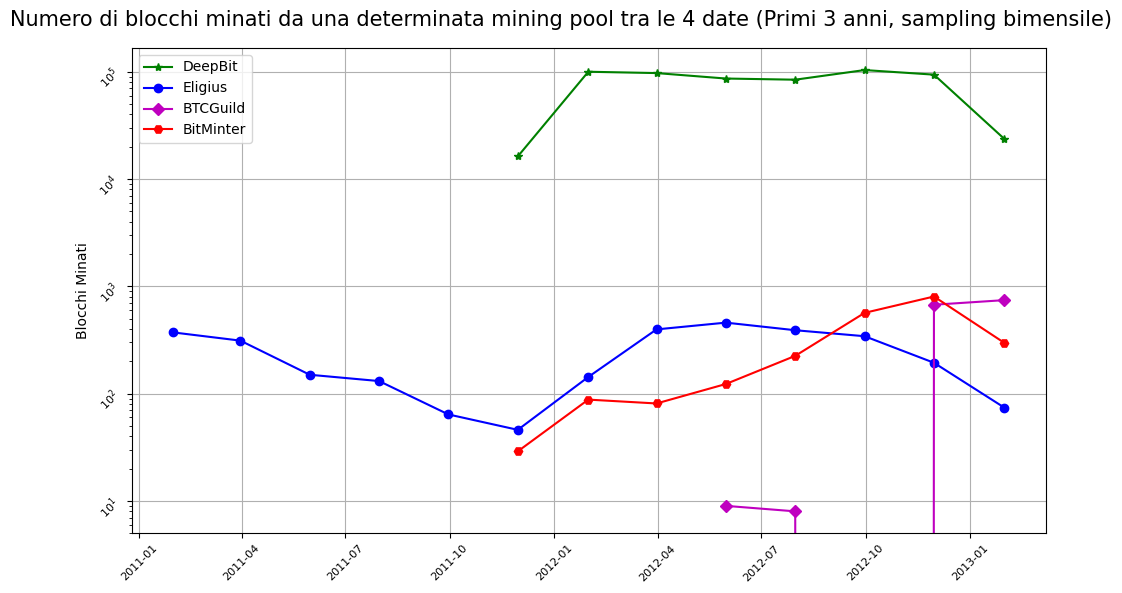

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# plotto le diverse mining pools
ax.plot(DeepBit_df.index, DeepBit_df['blocks'], marker='*', color='g')
ax.plot(Eligius_df.index, Eligius_df['blocks'], marker='o', color='b')
ax.plot(BTCGuild_df.index, BTCGuild_df['blocks'],marker='D', color='m')
ax.plot(BitMinter_df.index, BitMinter_df['blocks'], marker='H', color='r')

# label asse y
ax.set_ylabel("Blocchi Minati")

# specifiche varie per il grafico
plt.legend(["DeepBit" , "Eligius" , "BTCGuild" , "BitMinter"])
plt.yscale('log')
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=8, rotation=45)
fig.suptitle("Numero di blocchi minati da una determinata mining pool tra le 4 date (Primi 3 anni, sampling bimensile)", fontsize=15) #Titolo

plt.tight_layout()  # Aggiusto lo spacing tra gli elementi
plt.show()

Come e' evidenziato nella paper si ottiene un grafo che mostra:

- DeepBit nel suo periodo di operazione dal 2011 alla fine del 2012 mostra un market share decisamente elevato

- Eligius mostra un market share piu' basso ma costante, fin da prima del 2011

- BitMinter non ha transazioni prima dell'ottobre 2011 e ha un market share in aumento

---

#### 1.3 Numero di blocchi minati dai 4 miner deanonimizzati

Per questo grafico uso i dataframe definiti al punto 0.2

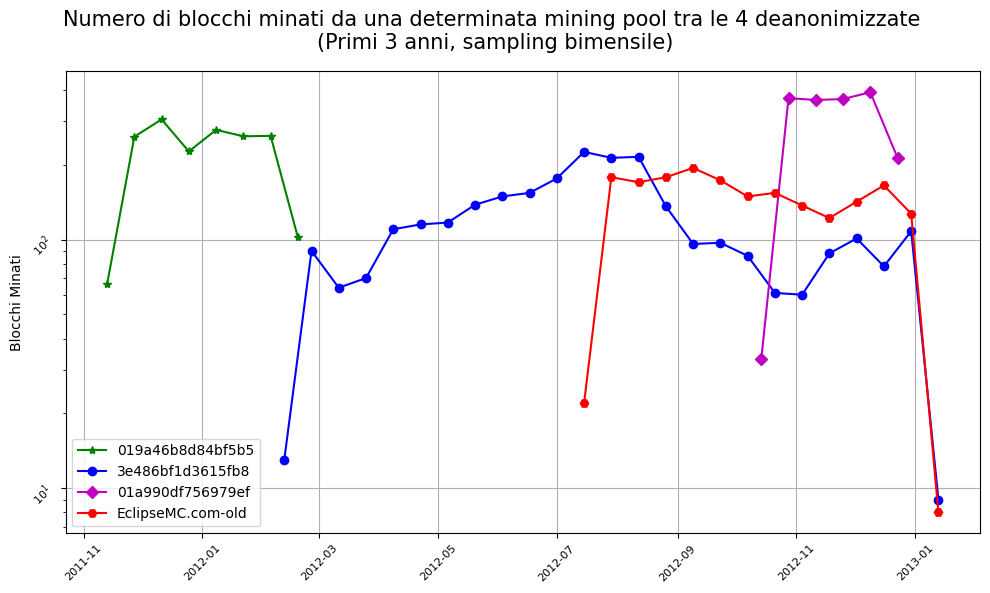

In [9]:
import matplotlib.pyplot as plt

# fig , axes = plt.subplot(figsize=(10,6))
fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(miner1_df.index, miner1_df['blocks'], marker='*', color='g')
ax.plot(miner2_df.index, miner2_df['blocks'], marker='o', color='b')
ax.plot(miner3_df.index, miner3_df['blocks'],marker='D', color='m')
ax.plot(EclipseMC_df.index, EclipseMC_df['blocks'], marker='H', color='r')

ax.set_ylabel("Blocchi Minati")
plt.legend(["019a46b8d84bf5b5" , "3e486bf1d3615fb8" , "01a990df756979ef" , "EclipseMC.com-old"])

plt.yscale('log')
plt.grid(True)

plt.tick_params(axis='both', which='major', labelsize=8, rotation=45)
fig.suptitle("Numero di blocchi minati da una determinata mining pool tra le 4 deanonimizzate \n(Primi 3 anni, sampling bimensile)", fontsize=15) #Titolo

plt.tight_layout()  # Aggiusto lo spacing tra gli elementi
plt.show()


### 2. Rewards guadagnate dalle diverse mining pools

Definiamo le reward di una mining pool come la somma di:
- Le `amount` delle transazioni coinbase dato che sono transazioni che generano BitCoin da aggiungere alla catena rilasciandoli come coin nuovi nel wallet del miner che ha minato quel blocco.
- La somma delle `fees` raccolte dalle transazioni da quella mining pool in un determinato periodo.

In [10]:
#apertura e filtro del DataSet di outputs con i txIds delle transazioni coinbase
temp = pd.read_csv("./datasets/outputs.csv", 
                  names=['txId', 'position', 'adressId', 'amount','scripttype'], 
                  dtype={'txId':'int32','position':'int32','adressId':'int64','amount':'int64','scripttype':'category'})
temp.drop(['position' , 'adressId', 'scripttype'], axis=1, inplace=True)
temp = temp[temp['txId'].isin(valid_txid)]
temp

,txId,amount
0,0,5000000000
1,1,5000000000
2,2,5000000000
3,3,5000000000
4,4,5000000000
...,...,...
24610683,10571747,2536100000
24612141,10572165,2521430000
24612807,10572424,2500000000
24612808,10572425,2505524214


In [11]:
# faccio una join per aggiungere le amount delle transazioni coinbase al dataframe
odf = odf.join(temp['amount'] , on="txId" , how="left")
odf['amount'] = odf['amount'].fillna(0)
odf

,Unnamed: 0,txId,adressId,hash,mining_pool,timestamp,fee,blockId,amount
0,0,0.0,0.0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,Other,2009-01-03 18:15:05,0.0,0.0,5.000000e+09
1,1,1.0,1.0,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,Other,2009-01-09 02:54:25,0.0,1.0,5.000000e+09
2,2,2.0,2.0,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,Other,2009-01-09 02:55:44,0.0,2.0,5.000000e+09
3,3,3.0,3.0,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,Other,2009-01-09 03:02:53,0.0,3.0,5.000000e+09
4,4,4.0,4.0,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,Other,2009-01-09 03:16:28,0.0,4.0,5.000000e+09
...,...,...,...,...,...,...,...,...,...
24613798,24613794,10572825.0,8707915.0,1DYve98WqJQmx6cDdW2EQFpnqfwptjV4e9,Other,2012-12-31 23:52:37,100000.0,214562.0,0.000000e+00
24613799,24613795,10572825.0,6137715.0,1AdN2my8NxvGcisPGYeQTAKdWJuUzNkQxG,Other,2012-12-31 23:52:37,100000.0,214562.0,0.000000e+00
24613800,24613796,10572826.0,8707915.0,1DYve98WqJQmx6cDdW2EQFpnqfwptjV4e9,Other,2012-12-31 23:52:37,100000.0,214562.0,0.000000e+00
24613801,24613797,10572826.0,6137711.0,1L4EThM6x3Rd2PjNbs1U136FpMq4Gmo3fJ,Other,2012-12-31 23:52:37,100000.0,214562.0,0.000000e+00


In [12]:
#definisco la colonna rewards come la somma, per ogni transazione delle sue fee e l'amount aggiunt (se la transazione e' coinbase)
odf['rewards'] = odf['fee'] + odf['amount']
# odf

#### 2.1 Rewards totali

DeepBit_net 18908844713833.0
Eligius_st 607601948800.0
3e486bf1d3615fb8 74177301129.0
BitMinter_com 52096049963.0
EclipseMC.com-old 22166254083.0
019a46b8d84bf5b5 68491489353.0
01a990df756979ef 15466935170.0
BTCGuild_com 476222581.0


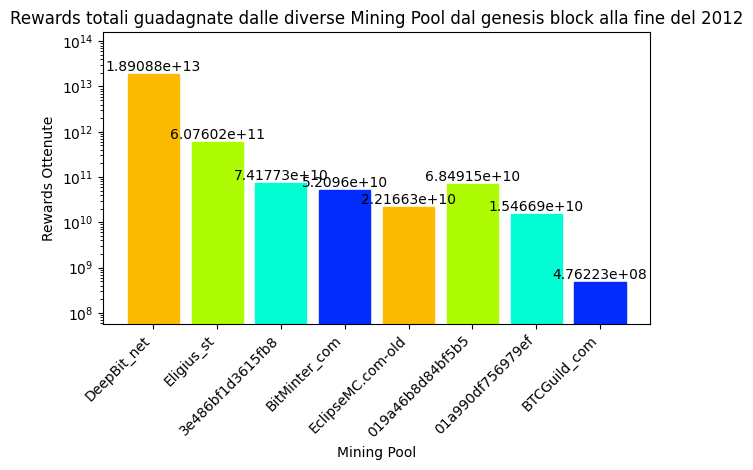

In [13]:
import matplotlib.pyplot as plt
blocks_mined = odf[odf["mining_pool"] != "Other"]
blocks_mined = blocks_mined["mining_pool"].value_counts()
blocks_mined = pd.DataFrame(blocks_mined)

mining_pools_list =['DeepBit_net','Eligius_st','3e486bf1d3615fb8','BitMinter_com', 'EclipseMC.com-old', '019a46b8d84bf5b5', '01a990df756979ef','BTCGuild_com']
pools = []

for mining_pool in mining_pools_list:
  print(mining_pool , odf[odf['mining_pool'] == mining_pool]['rewards'].sum())
  pools.append(odf[odf['mining_pool'] == mining_pool]['rewards'].sum())

fig, ax = plt.subplots()
bars = ax.bar(mining_pools_list , pools)
ax.bar_label(bars)

bars[0].set_color("#fcba03")
bars[1].set_color("#adfc03")
bars[2].set_color("#03fcd3")
bars[3].set_color("#032cfc")
bars[4].set_color("#fcba03")
bars[5].set_color("#adfc03")
bars[6].set_color("#03fcd3")
bars[7].set_color("#032cfc")

# Customize the plot further (title, labels, etc.)
plt.yscale('log')
plt.title("Rewards totali guadagnate dalle diverse Mining Pool dal genesis block alla fine del 2012")
plt.xlabel("Mining Pool")
plt.ylabel("Rewards Ottenute")

ax.margins(y=0.2)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align right
plt.tight_layout()
plt.show()

#### 2.2 Definisco le colonne dei rewards con un resampling bimensile per le 4 mining pools date

In [34]:
Eligius_df['rewards'] = odf[odf['mining_pool'] == "Eligius_st"].resample('2ME' , on='timestamp')[['rewards']].sum()

BitMinter_df['rewards'] = odf[odf['mining_pool'] == "BitMinter_com"].resample('2ME' , on='timestamp')[['rewards']].sum()

DeepBit_df['rewards']= odf[odf['mining_pool'] == "DeepBit_net"].resample('2ME' , on='timestamp')[['rewards']].sum()

BTCGuild_df['rewards']= odf[odf['mining_pool'] == "BTCGuild_com"].resample('2ME' , on='timestamp')[['rewards']].sum()

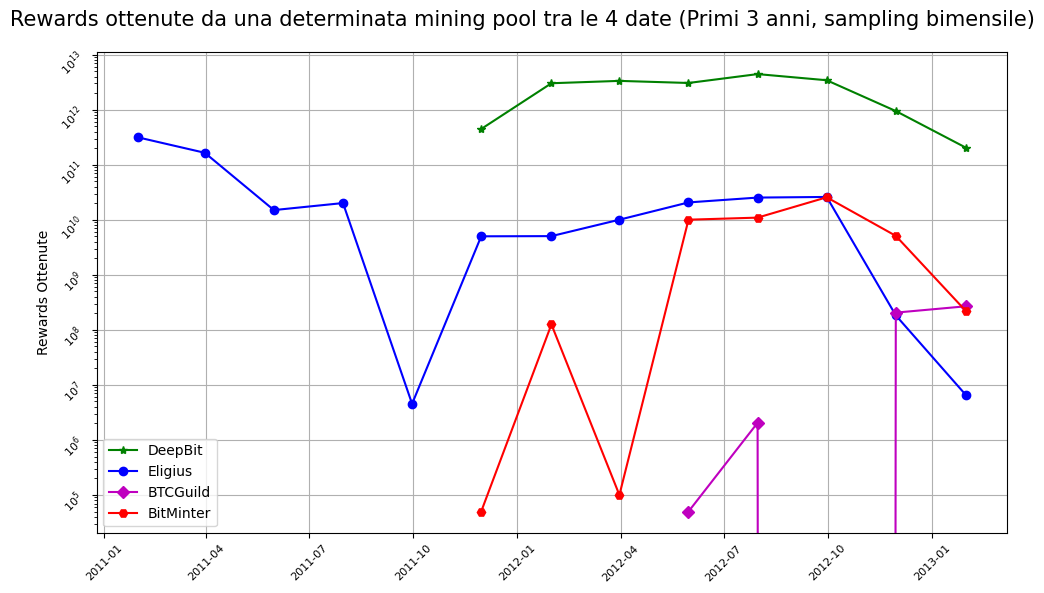

In [35]:
import matplotlib.pyplot as plt

# fig , axes = plt.subplot(figsize=(10,6))
fig, ax = plt.subplots(figsize=(10, 6))

#plot dei dati
ax.plot(DeepBit_df.index, DeepBit_df['rewards'], marker='*', color='g')
ax.plot(Eligius_df.index, Eligius_df['rewards'], marker='o', color='b')
ax.plot(BTCGuild_df.index, BTCGuild_df['rewards'],marker='D', color='m')
ax.plot(BitMinter_df.index, BitMinter_df['rewards'], marker='H', color='r')

ax.set_ylabel("Rewards Ottenute")

# spacifiche varie
plt.legend(["DeepBit" , "Eligius" , "BTCGuild" , "BitMinter"])
plt.yscale('log')
plt.grid(True)

plt.tick_params(axis='both', which='major', labelsize=8, rotation=45)
fig.suptitle("Rewards ottenute da una determinata mining pool tra le 4 date (Primi 3 anni, sampling bimensile)", fontsize=15) #Titolo

plt.tight_layout()  # Aggiusto lo spacing tra gli elementi
plt.show()


#### 2.3 Definisco le colonne dei rewards con resampling bisettimanale dei rewards dei 4 miner deanonimizzati

In [36]:
miner1_df['rewards'] = odf[odf['mining_pool'] == "019a46b8d84bf5b5"].resample('2W' , on='timestamp')[['rewards']].sum()
miner2_df['rewards'] = odf[odf['mining_pool'] == "3e486bf1d3615fb8"].resample('2W' , on='timestamp')[['rewards']].sum()
EclipseMC_df['rewards'] = odf[odf['mining_pool'] == "EclipseMC.com-old"].resample('2W' , on='timestamp')[['rewards']].sum()
miner3_df['rewards'] = odf[odf['mining_pool'] == "01a990df756979ef"].resample('2W' , on='timestamp')[['rewards']].sum()

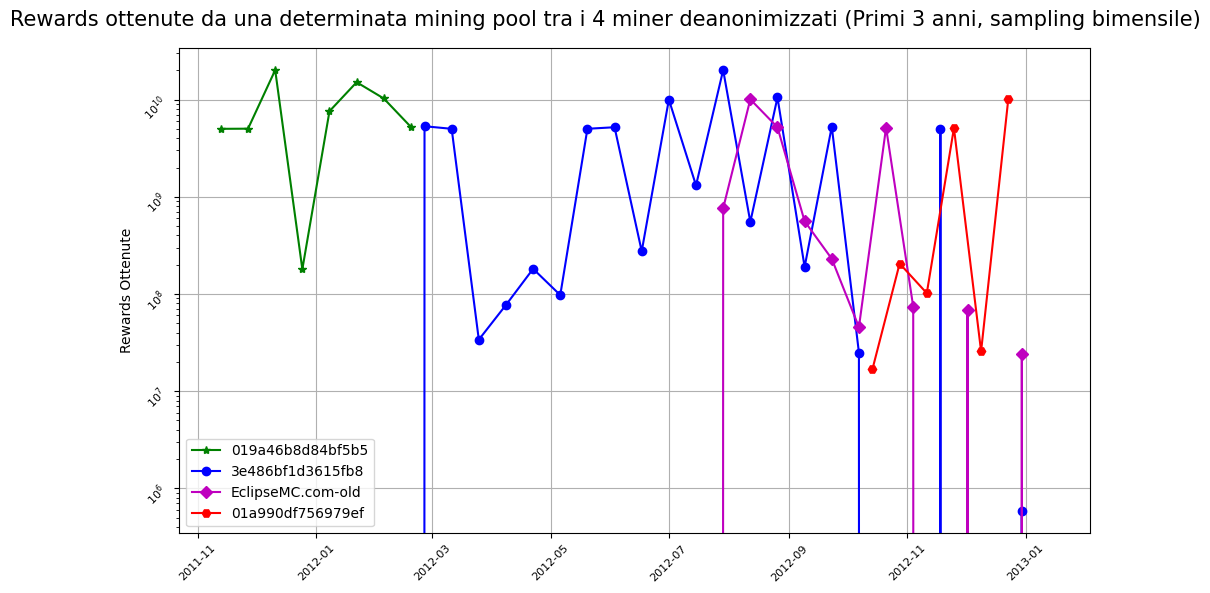

In [37]:
import matplotlib.pyplot as plt

# fig , axes = plt.subplot(figsize=(10,6))
fig, ax = plt.subplots(figsize=(10, 6))

#plot dei dati
ax.plot(miner1_df.index, miner1_df['rewards'], marker='*', color='g')
ax.plot(miner2_df.index, miner2_df['rewards'], marker='o', color='b')
ax.plot(EclipseMC_df.index, EclipseMC_df['rewards'],marker='D', color='m')
ax.plot(miner3_df.index, miner3_df['rewards'], marker='H', color='r')

ax.set_ylabel("Rewards Ottenute")

# spacifiche varie
plt.legend(["019a46b8d84bf5b5" , "3e486bf1d3615fb8" , "EclipseMC.com-old" , "01a990df756979ef"])
plt.yscale('log')
plt.grid(True)

plt.tick_params(axis='both', which='major', labelsize=8, rotation=45)
fig.suptitle("Rewards ottenute da una determinata mining pool tra i 4 miner deanonimizzati (Primi 3 anni, sampling bimensile)", fontsize=15) #Titolo

plt.tight_layout()  # Aggiusto lo spacing tra gli elementi
plt.show()


## Taint analysis di una transazione di `Eligius`

- `txId` : c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6

Faccio ora la taint analysis della transazione, creando un grafo che rappresenti tutte le transazioni che possono essere rincondotte all'output della transazione di partenza.

Per questo verranno riutilizzate le helper functions per lo scraping definite sopra : `generate_proxies` e `get_request_page`.

In aggiunta verra' usata la libreria `random` per aiutare a colorare il grafo

In [14]:
import random
r = lambda: random.randint(100,255) #usata per generare un colore random

- definisco una funzione di scraping che dato un `txId` mi restituisce una lista contenente tutti gli `txIds` dell'output di quella transazione

In [15]:
def get_txId_outputs(txId):
  url = f"https://www.walletexplorer.com/txid/{txId}"
  r = get_request_page(url, proxies)
  soup = bs(r.text , "html.parser")

  outputs = []

  table = soup.select("#main > table.tx > tr:nth-child(2) > td:nth-child(2)")[0]

  for td in table.find_all('td' , attrs={'class':'small'}):
    if td.text == "unspent" : continue
    outputs.append(td.find("a")['href'].replace("/txid/", ""))

  return outputs

- definisco una funzione ricorsiva che viene utilizzata per aggiornare il grafico

In [16]:
def graph_update(g ,txId , step):
  if step <= 0 : return
  
  outs = get_txId_outputs(txId)

  for tx in outs:
    g.add_node(tx, level=step)
    g.add_edge(txId , tx)
    graph_update(g , tx , step-1)

#### creazione del grafo

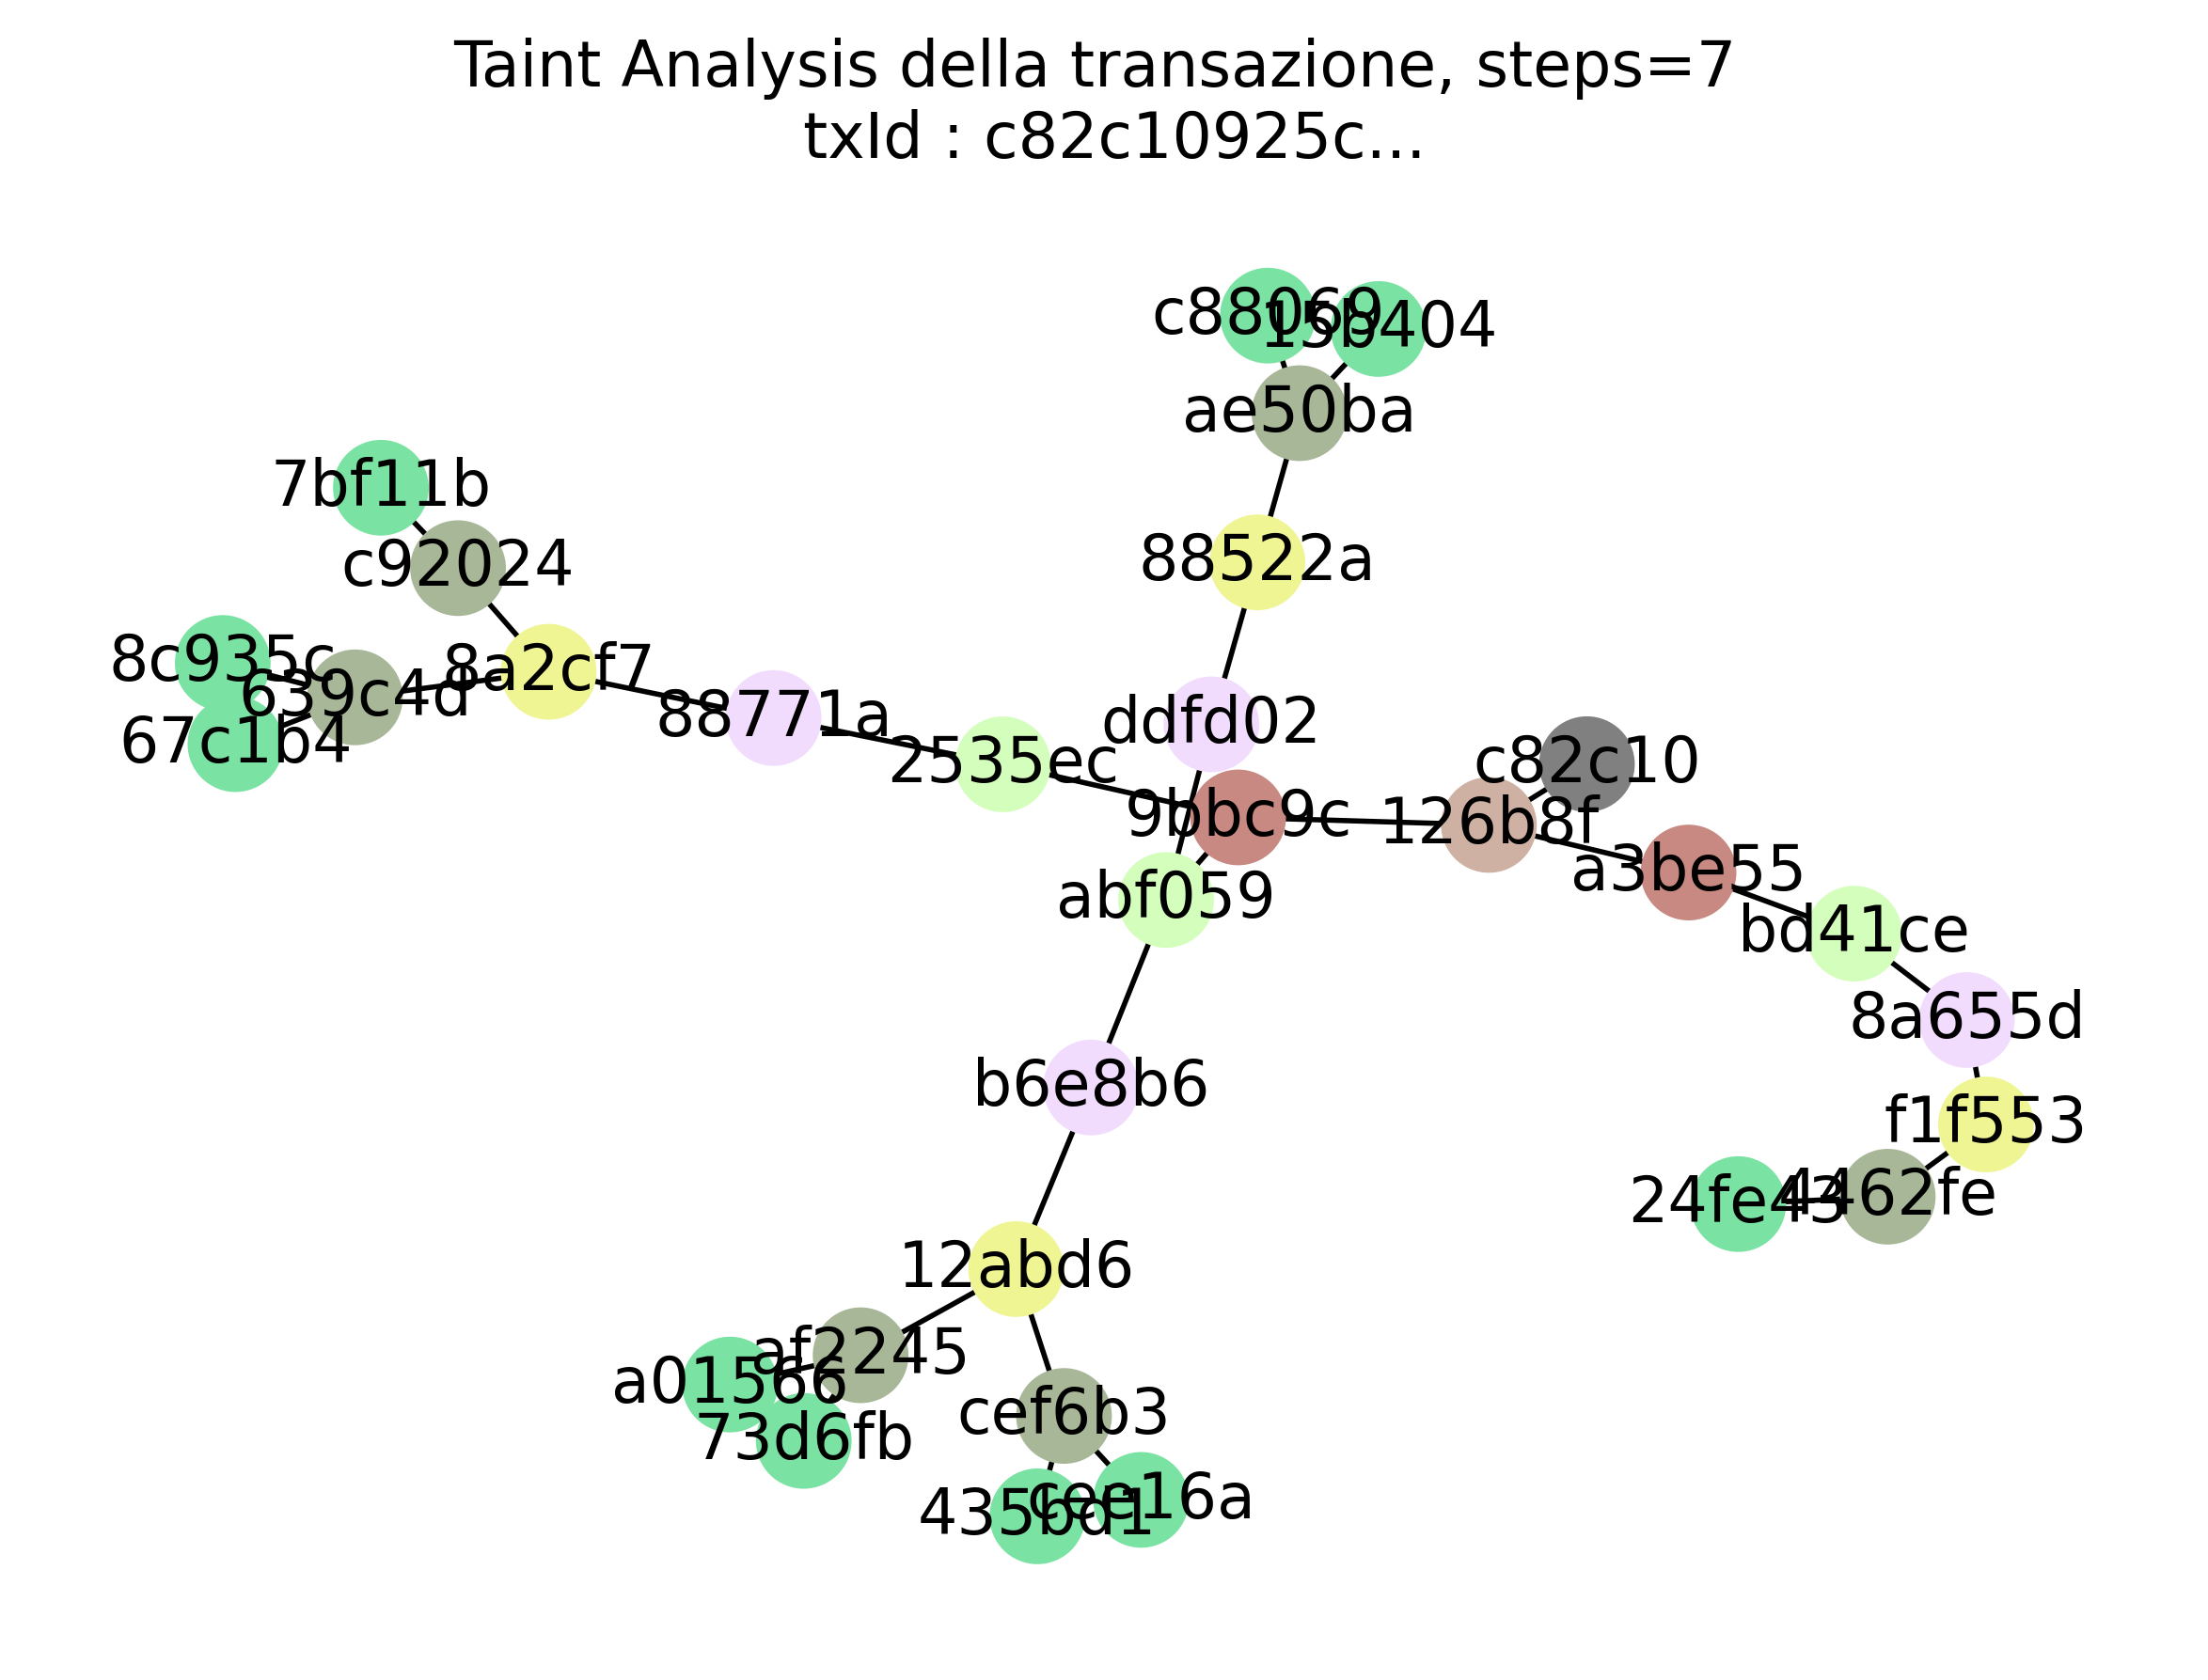

In [29]:
#importo la libreria per i grafi e definisco il grafo g
import networkx as nx 
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=400)
g = nx.Graph()

#definisco i parametri : tx di partenza e il numero di step che devono essere fatti
start = "c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6"
steps = 7

#definisco una lista associare i colori ai nodi 
#e un dict per definire quale colore va associato a quale step
colors = []
color_scheme = {}
for step in range(1, steps+1):
  color_scheme[str(step)] = '#%02X%02X%02X' % (r(),r(),r()) #converto il colore RGB => HEX

# #aggiungo il nodo di partenza al grafo
g.add_node(start)

# #chiamo la funzione di update
graph_update(g , start , steps)

#rinomino i nodi con l'inizio del loro nome per evitare un overcrowd del grafico e ci applico i colori
g = nx.relabel_nodes(g , lambda txId : txId[0:6])
node_colors = [color_scheme.get(str(g.nodes[node].get('level', 0)), 'gray') for node in g.nodes()]

#giusto due abbellimenti al grafo
plt.title(f"Taint Analysis della transazione, steps={steps} \n txId : {start[0:10]}...")
plt.tight_layout()

g_pos = nx.spring_layout(g)
nx.draw(g, with_labels=True, pos=g_pos, node_color = node_colors)